# Problem Background
* Data Challenge from **CompanyY** Insurance group
* **CompanyY** is a B2B insurance company offering employee benefits products to employers across the US
* The Corporate Marketing Analytics Team wants to identify high potential targets for sales of **ProductX**
* Real world data provided on employer characteristics, sales activity, and geographic location
* Design model for recommending **ProductX** given the data provided

**My Approach**

* Predict sale success ("sold" or "lost") of **ProductX**  based on features provided
* Additional data and resources used:
    * [US Census Bureau: County Business Patterns - 2017](https://www.census.gov/data/datasets/2017/econ/cbp/2017-cbp.html) 
    * [OECD: Enterprises by business size definition](https://data.oecd.org/entrepreneur/enterprises-by-business-size.htm)

In [57]:
# For File manangement
import sys as sys
import os as os

# For data manipulations
import pandas as pd
import numpy as np

# For visualizations
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D

# For splitting, cross validating, standardizing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [58]:
# os.getcwd()

In [59]:
# Employers data
employers = pd.read_csv("../exercise/data/employers.csv", index_col = 'EmployerId')
employers.head()

,ClientTenure,Employees,Industry,NetworkStrength,ZipCode
EmployerId,,,,,
409551605,3,10,I12,0.5073,14301
848679,27,22,I12,-0.1249,78229
664144005,5,168,I20,-0.0671,48529
604857,25,19,I27,0.7818,45429
128777227,6,12,I19,-0.4495,16335


In [60]:
# Geography data
geography = pd.read_csv("../exercise/data/geography.csv", engine='python')
geography.head()

,zip,city,latitude,longitude,fips,county,population,state,cbsa,cbsa_name
0,210,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
1,211,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
2,212,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
3,213,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton
4,214,Portsmouth,43.005895,-71.013202,33015,Rockingham County,295223,NH,14460,Boston-Cambridge-Newton


In [61]:
# Quotes data: Sales activity
quotes = pd.read_csv("../exercise/data/quotes.csv", index_col = 'EmployerId')
quotes.rename(columns = {'Status':'success'},inplace = True)
quotes.head()

,Offered,success
EmployerId,,
363773443,ProductX,Lost
186941116,ProductX,Lost
511147993,ProductX,Lost
46777684,ProductX,Lost
115068663,ProductX,Lost


In [62]:
# US Census Bureau data zipcode level data: County Business Patterns - First Quarter 2017
county_bus = pd.read_csv("../exercise/data/zbp17totals.txt")
county_bus.rename(columns = {'qp1':'tot_payroll_q1', 'ap':'tot_payroll_annual','est':'tot_employers'}, inplace = True)
county_bus = county_bus[['zip', 'tot_payroll_q1','tot_payroll_annual','tot_employers']]
county_bus.head()

,zip,tot_payroll_q1,tot_payroll_annual,tot_employers
0,1001,96616,422470,473
1,1002,70277,299103,545
2,1003,2461,10380,21
3,1004,1422,5912,12
4,1005,8163,35287,94


# Data Cleaning & Preparation
* Merge files
* Filter data
* Feature engineering
* Impute missing values

In [63]:
# Changing columns data types: Helps with merging and summary stats
geography['zip'] = geography['zip'].astype(str)
county_bus['zip'] = county_bus['zip'].astype(str)
geography['state'] = geography.state.astype('category')
employers['Industry'] = employers.Industry.astype('category')

In [64]:
# Merge files
df_combined = pd.merge(left = employers, right = quotes, how = "left", left_on = "EmployerId", right_on = "EmployerId")
df_combined = pd.merge(left = df_combined, right = geography, how = "left", left_on = "ZipCode", right_on = "zip")
df_combined = pd.merge(left = df_combined, right = county_bus, how = "left", left_on = "zip", right_on = "zip")

In [65]:
# Filter for productX
df_combined = df_combined[df_combined.Offered == 'ProductX']
# Recode success feature: Sold =1, Lost = 0
df_combined['success'] = df_combined['success'].map({'Lost': 0, 'Sold': 1})
# Replace '?' with NaN in 'NetworkStrength'
df_combined["NetworkStrength"] = df_combined["NetworkStrength"].replace("?", np.NaN)
# Recode NetworkStrength to numeric
df_combined ["NetworkStrength"] = pd.to_numeric(df_combined["NetworkStrength"])
# Binning employees based on OECD enterprise size definitions
labels_emp = ["Micro","Small","Medium","Large"]
bins_emp = [0,10,50,250,np.inf] # Max on Employees = 135940
df_combined["company_size"] = pd.cut(df_combined['Employees'], bins=bins_emp, labels=labels_emp)
# Binning annual payroll income
labels_inc = ["Low","Lower-Middle","Middle","Upper Middle", "Upper"]
quantile = [0, 0.2,0.4,0.6,0.8,1]
df_combined["income_cat"] = pd.qcut(df_combined['tot_payroll_annual'], q=quantile, labels=labels_inc)

In [66]:
# Imputation of missing values
# Replace NaNs with Unknown for Industry'
df_combined['Industry'] = df_combined['Industry'].cat.add_categories("Unknown").fillna("Unknown")
# Median imputattion for the remaining features
df_combined.fillna(df_combined.median(), inplace=True)
# Drop remaining missing values
df_combined = df_combined.dropna() 

In [67]:
# Select relevant columns
df_sum = df_combined[['success', 'NetworkStrength', 'ClientTenure', 'Employees', 'state','Industry','population','tot_payroll_q1','tot_payroll_annual','tot_employers','company_size','income_cat']]
# Export to csv
# df_sum.to_csv("./insurance.csv")

In [68]:
# Shape of dataframe
df_combined.shape 

(7075, 22)

# Descriptive Statistics

In [69]:
# All numeric features
df_sum.describe()

,success,NetworkStrength,ClientTenure,Employees,population,tot_payroll_q1,tot_payroll_annual,tot_employers
count,7075.000000,7075.000000,7075.000000,7075.000000,7.075000e+03,7.075000e+03,7.075000e+03,7075.000000
mean,0.228269,0.200990,10.034346,115.457385,1.237715e+06,3.870538e+05,1.448411e+06,1075.141767
std,0.419746,0.522766,10.101833,1744.003029,1.846394e+06,6.510820e+05,2.154560e+06,758.120901
min,0.000000,-2.115100,1.000000,1.000000,9.820000e+02,0.000000e+00,0.000000e+00,4.000000
25%,0.000000,-0.112400,2.000000,16.000000,1.974650e+05,8.337750e+04,3.484930e+05,529.500000
50%,0.000000,0.240100,6.000000,31.000000,6.266810e+05,1.900980e+05,7.864350e+05,947.000000
75%,0.000000,0.573950,16.000000,66.000000,1.202362e+06,4.136790e+05,1.644682e+06,1477.000000
max,1.000000,2.537700,119.000000,135940.000000,9.818605e+06,8.525837e+06,2.436443e+07,7277.000000


In [70]:
# All categorical features
df_sum.describe(include = 'category')

,state,Industry,company_size,income_cat
count,7075,7075,7075,7075
unique,43,28,4,5
top,TX,Unknown,Small,Upper Middle
freq,933,1349,4082,1419


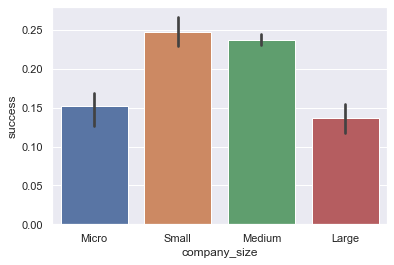

In [71]:
# Income Quantile and employer size
df_income_cat = df_sum.groupby(['income_cat', 'company_size'])['success'].aggregate(np.mean).reset_index().sort_values('success')
sns.barplot(x = 'company_size', y = 'success', data = df_income_cat)

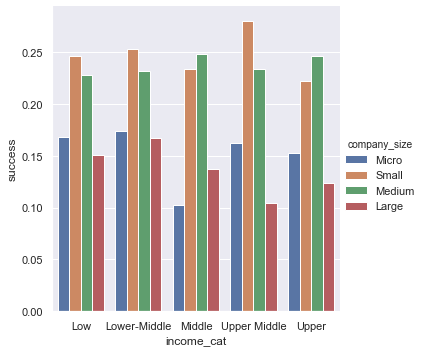

In [72]:
# Company size and Income
sns.catplot(x = "income_cat",   y = 'success', kind = 'bar', hue = 'company_size', data=df_income_cat)

In [73]:
# Industry
indus_result = df_sum.groupby(["Industry"])['success'].aggregate(np.mean).reset_index().sort_values('success')
# Top 20
indus_result = indus_result.tail(20)
# State
state_result = df_sum.groupby(["state"])['success'].aggregate(np.mean).reset_index().sort_values('success')
# Drop missing 'success' values
state_result = state_result.dropna() 
# Top 20
state_result = state_result.tail(20)

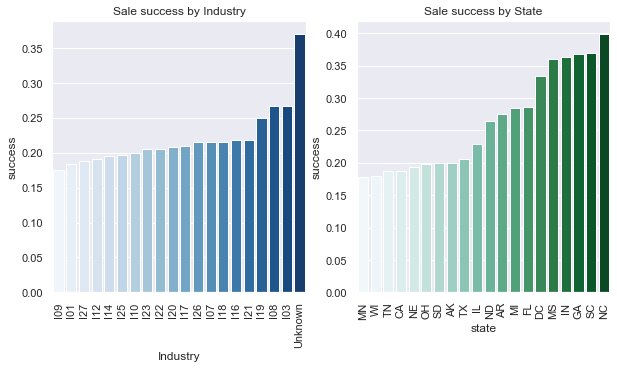

In [74]:
# Plots
plt.subplot(1,2,1)
sns.barplot(x='Industry', y='success', data=indus_result, order= indus_result['Industry'], palette= 'Blues')
plt.title("Sale success by Industry")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
state_result = state_result.tail(20)
sns.barplot(x='state', y= 'success', data=state_result, order= state_result['state'], palette= "BuGn")
plt.title("Sale success by State")
plt.xticks(rotation=90)

# Aesthetics
plt.subplots_adjust(wspace = 0.2, hspace = 0)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

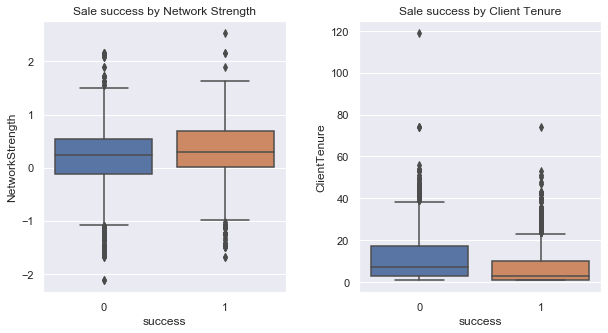

In [75]:
# Continous features
plt.subplot(1,2,1)
sns.boxplot(x='success', y="NetworkStrength", data=df_sum)
plt.title("Sale success by Network Strength")

plt.subplot(1,2,2)
sns.boxplot(x='success', y="ClientTenure", data=df_sum)
plt.title("Sale success by Client Tenure")

# Aesthestics
plt.subplots_adjust(wspace = 0.3, hspace = 0)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

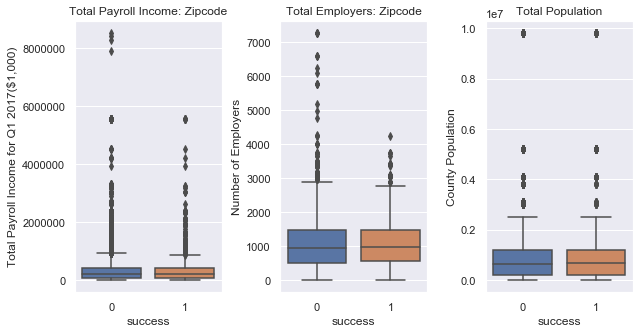

In [76]:
# County Business indicators
plt.subplot(1,3,1)
sns.boxplot(x='success', y="tot_payroll_q1", data=df_sum)
plt.title("Total Payroll Income: Zipcode")
plt.ylabel('Total Payroll Income for Q1 2017($1,000)')

plt.subplot(1,3,2)
sns.boxplot(x='success', y="tot_employers", data=df_sum)
plt.title("Total Employers: Zipcode")
plt.ylabel('Number of Employers')

plt.subplot(1,3,3)
sns.boxplot(x='success', y="population",data=df_sum)
plt.title("Total Population")
plt.ylabel('County Population')

plt.subplots_adjust(wspace= 0.4, hspace = 0.1)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

# Machine Learning Preparation
* Check for imbalanced classes
* One-hot-encoding for categorical features

Text(0, 0.5, 'Count of observations')

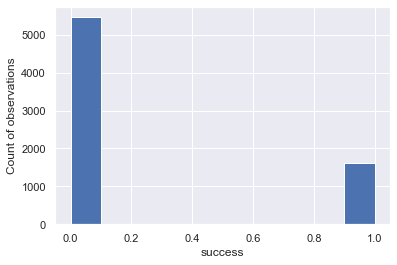

In [77]:
# Check for inbalanced classes
plt.hist(df_sum.success)
plt.xlabel("success")
plt.ylabel("Count of observations")

In [78]:
# Rebalancing of classes
# generate special classes for types
#count0, count1 = df_sum.success.value_counts()
#aclass0 = df_sum[df_sum.success==0]
#aclass1 = df_sum[df_sum.success==1]
#print(count0)
#print(count1)

In [79]:
# over sampling for class 1 
# Generate a new sample of count0 items of count1
#over1 = aclass1.sample(count0,replace=True)
#df_sum = pd.concat([aclass0,over1],axis=0)
#print(len(over1))
#plt.hist(df_sum.success)
#plt.xlabel("success")
#plt.ylabel("Count of observations")

# Random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the
# minority class examples. In this way, a symbolic classifier, for instance, might construct rules that are
# apparently accurate, but actually cover one replicated example.

In [80]:
df_sum.shape

(7075, 12)

In [81]:
# Drop categorical variables created: company_size & income_cat
df_ml = df_sum.drop(['company_size', 'income_cat'], axis=1)
# One-hot encoding: state & industry
df_ml = pd.get_dummies(df_ml, prefix=['state', 'industry'], columns=['state', 'Industry'])
df_ml.shape

(7075, 87)

In [82]:
# Create y and X features: *important step*
y = df_ml['success']
X = df_ml.iloc[:, 1:] 

In [83]:
# X features
X.columns

Index(['NetworkStrength', 'ClientTenure', 'Employees', 'population',
       'tot_payroll_q1', 'tot_payroll_annual', 'tot_employers', 'state_AK',
       'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY', 'industry_I01', 'industry_I02', 'industry_I03',
       'industry_I04', 'industry_I05', 'industry_I06', 'industry_I07',
       'industry_I08', 'industry_I09', 'industry_I10', 'industry_I11',
  

In [84]:
# y feature
y.name

'success'

In [ ]:
# Set up Monte-carlo experiment
def MCtraintest(nmc,X,y,modelObj,testFrac):
    trainScore = np.zeros(nmc)
    testScore  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testFrac)
        modelObj.fit(X_train,y_train)
        trainScore[i] = modelObj.score(X_train,y_train)
        testScore[i]  = modelObj.score(X_test,y_test)
    return trainScore,testScore

# Set parameters 
nmc = 25
testFrac = 0.25

# Machine Learning Algorithms
* This is a classification tasks as such will only consider classification models

## Logistic Regression
* Default parameters
* Grid search
* Best Model
* Model interpretation: Coefficients

In [32]:
from sklearn.linear_model import LogisticRegression
fullModel = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.7779
Testing Set Accuracy: 0.7778


In [33]:
# Grid search
clist = np.power(10.,range(-8,2))
fullModel = make_pipeline(StandardScaler(),LogisticRegression())
# set up dictionary for grid search
# dictionary name must now include pipeline function name then __
param_grid={'logisticregression__C':clist,'logisticregression__max_iter':[3000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_logisticregression__C']]

# Highlight Orange best model Function
def highlight_col(x):
    # copy df to new - original data are not changed
    df = x.copy()
    # Hightlight orange highest ranked model
    mask = df['rank_test_score'] == 1
    df.loc[mask, :] = 'background-color: orange'
    df.loc[~mask,:] = 'background-color: ""'
    return df 

# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_logisticregression__C
0,5,0.771127,0.773544,0.000000
1,5,0.771127,0.773544,0.000000
2,5,0.771127,0.773544,0.000001
3,5,0.771127,0.773544,0.000010
4,5,0.771127,0.773544,0.000100
5,5,0.771127,0.773544,0.001000
6,4,0.776502,0.777818,0.010000
7,3,0.777422,0.777954,0.100000
8,1,0.777671,0.778089,1.000000
9,1,0.777603,0.778089,10.000000


Text(0.5, 1.0, 'Regularization in Logistic Regression')

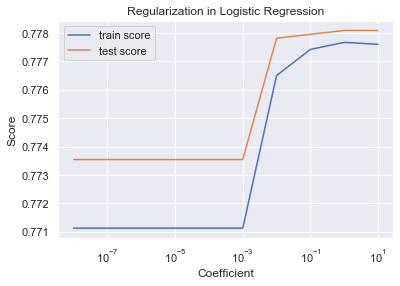

In [34]:
# Regularization Plot
plt.semilogx(clist, df_results['mean_train_score'],label="train score")
plt.semilogx(clist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in Logistic Regression")

## Nearest Neighbour
* Default parameters
* Grid search
* Best Model

In [35]:
from sklearn.neighbors import KNeighborsClassifier
fullModel = make_pipeline(StandardScaler(), KNeighborsClassifier())
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.8090
Testing Set Accuracy: 0.7400


Text(0.5, 1.0, 'Regularization in Nearest Neighbour')

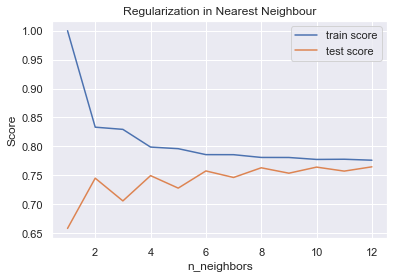

In [36]:
# Grid search:
neighborRange = np.arange(1,13)
trainList = np.zeros(len(neighborRange))
testList  = np.zeros(len(neighborRange))
for j in neighborRange:
    knnc = KNeighborsClassifier(n_neighbors=j)
    trainScore,testScore = MCtraintest(100,X,y,knnc,0.25)
    trainList[j-1] = np.mean(trainScore)
    testList[j-1] = np.mean(testScore)
    
plt.plot(neighborRange,trainList,label="train score")
plt.plot(neighborRange,testList,label="test score")
plt.ylabel("Score")
plt.xlabel("n_neighbors")
plt.legend()
plt.title("Regularization in Nearest Neighbour")

## Suppport Vector Classifier
* Default parameters
* Grid search
* Best Model

In [37]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

fullModel = make_pipeline(StandardScaler(), LinearSVC())
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.7758
Testing Set Accuracy: 0.7756


In [38]:
# Grid search 
clist = np.power(10.,range(-5,10))
fullModel = make_pipeline(StandardScaler(),LinearSVC())
# set up dictionary for grid search
# Dictionary name must now include pipeline function name then __
param_grid={'linearsvc__C':clist,'linearsvc__max_iter':[3000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_linearsvc__C']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_linearsvc__C
0,6,0.774617,0.777886,0.000010
1,1,0.775982,0.778858,0.000100
2,3,0.775733,0.778632,0.001000
3,5,0.775846,0.778519,0.010000
4,2,0.775763,0.778722,0.100000
5,4,0.775688,0.778609,1.000000
6,7,0.770373,0.772911,10.000000
7,8,0.691248,0.689248,100.000000
8,9,0.657113,0.656235,1000.000000
9,11,0.652341,0.645291,10000.000000


Text(0.5, 1.0, 'Regularization in SVC')

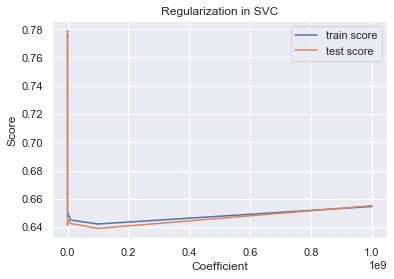

In [39]:
# Regularization Plot
plt.plot(clist, df_results['mean_train_score'],label="train score")
plt.plot(clist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in SVC")

##  Naive Bayes Classifier
* Verify Gaussian assumptions
* Default parameters
* Grid search
* Best Model

In [40]:
# Verify model assumptions
# Check for multicolinearity: VIF > 5 not good
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = X
vif = pd.DataFrame()
X_vif = X_vif.assign(const=1)
vif["vif_factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif.sort_values("vif_factor").round(3)

,vif_factor,features
86,0.000,const
2,1.009,Employees
1,1.128,ClientTenure
0,1.741,NetworkStrength
3,1.781,population
...,...,...
28,NaN,state_ME
33,NaN,state_MT
37,NaN,state_NH
46,NaN,state_RI


In [41]:
# Default parameters
from sklearn.naive_bayes import GaussianNB
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(GaussianNB(), X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.3078
Testing Set Accuracy: 0.3062


## Linear Discriminant Classifier

* Default parameters


In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
fullModel = make_pipeline(LinearDiscriminantAnalysis())
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.7767
Testing Set Accuracy: 0.7759


## Quadratic Discriminant Classifier
* Default parameters

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

fullModel = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.4221
Testing Set Accuracy: 0.4135


## Decision Trees
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Tree
    * Model importances

In [44]:
from sklearn.tree import DecisionTreeClassifier
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(DecisionTreeClassifier(), X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.9999
Testing Set Accuracy: 0.6864


In [45]:
# Grid Search
# Parameters
tree_depth = np.arange(start=2,stop=41,step=2,dtype=int)
param_grid={'max_depth':tree_depth}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(DecisionTreeClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth
0,2,0.775303,0.769022,2
1,1,0.784101,0.773250,4
2,3,0.795439,0.768728,6
3,4,0.816080,0.760136,8
4,5,0.843015,0.750458,10
5,6,0.873743,0.736936,12
6,7,0.901447,0.729542,14
7,8,0.923649,0.722125,16
8,9,0.941259,0.714347,18
9,10,0.955718,0.708219,20


Text(0.5, 1.0, 'Regularization in Decision Trees')

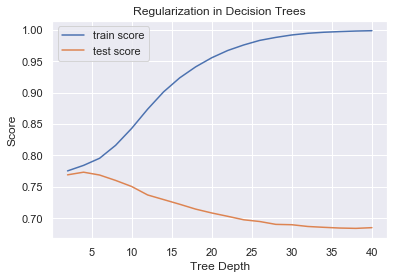

In [46]:
# Plot
plt.plot(tree_depth, df_results['mean_train_score'],label="train score")
plt.plot(tree_depth, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Tree Depth")
plt.legend()
plt.title("Regularization in Decision Trees")

In [47]:
# Analyze tree
X_train, X_test, y_train, y_test = train_test_split(X,y)
dt = DecisionTreeClassifier(max_depth=4, random_state=0)
dt.fit(X_train, y_train)

print("Training Set Accuracy: {:.4f}".format(dt.score(X_train, y_train)))
print("Testing Set Accuracy: {:.4f}".format(dt.score(X_test, y_test)))

Training Set Accuracy: 0.7835
Testing Set Accuracy: 0.7716


In [48]:
# Tree
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file="tree.dot", class_names=["Lost", "Sold"],
                feature_names= X.columns, impurity=False, filled=True)

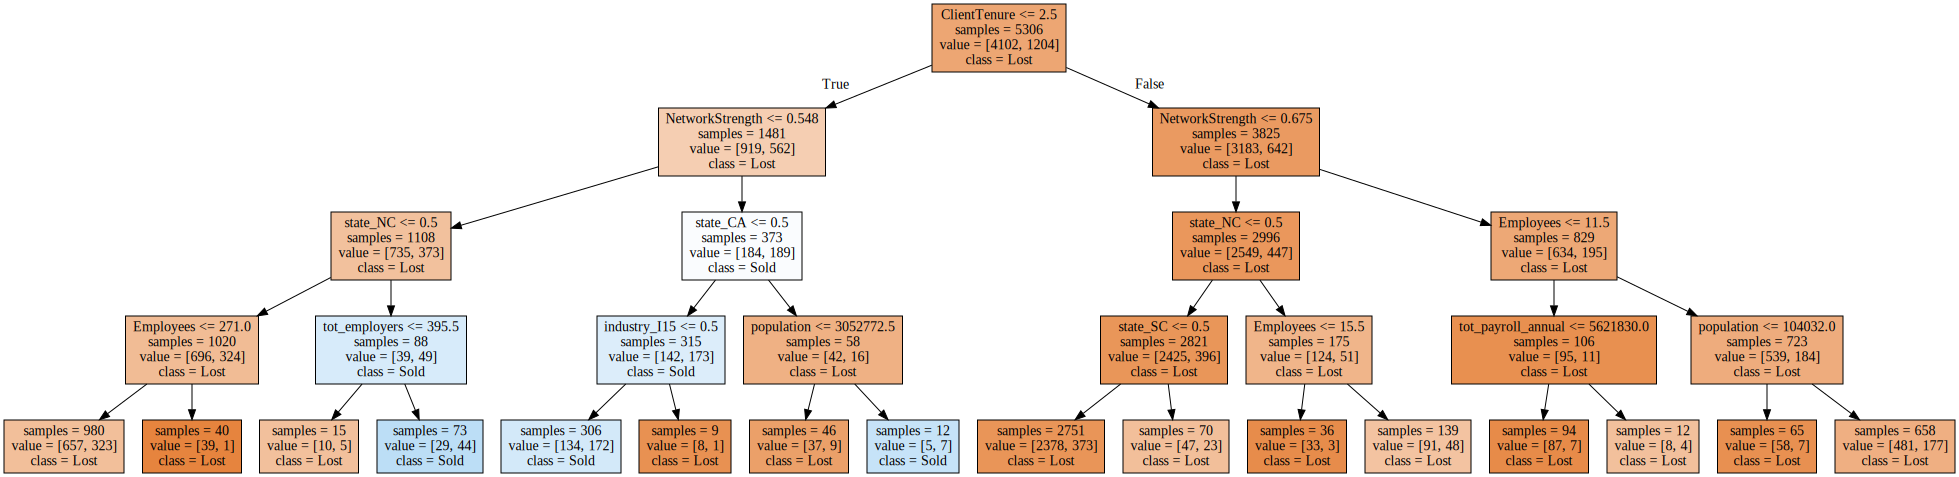

In [49]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

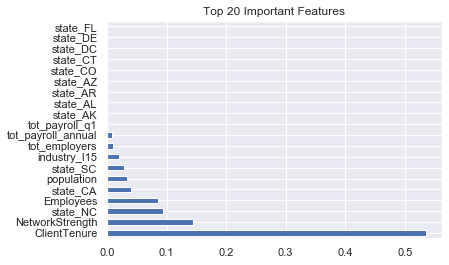

In [50]:
# Feature importances
def plot_feature_importances(model):
    # Display feature importances
    importances = model.feature_importances_
    # Sort feature importances in descending order
    # Rearrange feature names so they match the sorted feature importances
    # Filter for top 20 importances
    (pd.Series(model.feature_importances_, index=X.columns)
    # Filter for top 20 importances
    .nlargest(20)
    .plot(kind='barh'))
    plt.title("Top 20 Important Features")
plot_feature_importances(dt)

## Random Forests
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Model Importances

In [51]:
from sklearn.ensemble import RandomForestClassifier
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(RandomForestClassifier(), X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.9999
Testing Set Accuracy: 0.7690


In [52]:
# Grid search
max_features_list = np.arange(start=1,stop= 11,step=1,dtype=int)
tree_depth_list   = np.arange(start=1,stop= 11,step=2,dtype=int)
# Set grid search
param_grid={'max_features':max_features_list,'max_depth':tree_depth_list,'n_estimators':[50]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth', 'param_max_features', 'param_n_estimators']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth,param_max_features,param_n_estimators
0,13,0.772529,0.769339,1,1,50
1,13,0.772529,0.769339,1,2,50
2,13,0.772529,0.769339,1,3,50
3,13,0.772529,0.769339,1,4,50
4,13,0.772529,0.769339,1,5,50
5,13,0.772529,0.769339,1,6,50
6,13,0.772529,0.769339,1,7,50
7,13,0.772529,0.769339,1,8,50
8,13,0.772529,0.769339,1,9,50
9,13,0.772529,0.769339,1,10,50


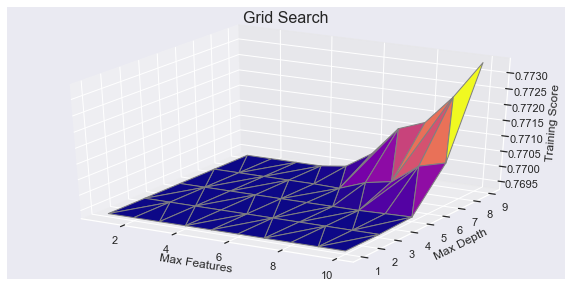

In [53]:
# 3D plot of Grid search results
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = df_results['param_max_features']
ys = df_results['param_max_depth']
zs = df_results['mean_test_score']

ax.set_xlabel("Max Features",fontsize = 12)
ax.set_ylabel("Max Depth",fontsize = 12)
ax.set_zlabel("Training Score", fontsize = 12)
ax.set_title("Grid Search", fontsize = 16)

# Aesthetics
fig.set_figheight(5)
fig.set_figwidth(10)
                   
ax.plot_trisurf(xs, ys, zs,color= 'blue',edgecolor='gray', cmap=cm.plasma)

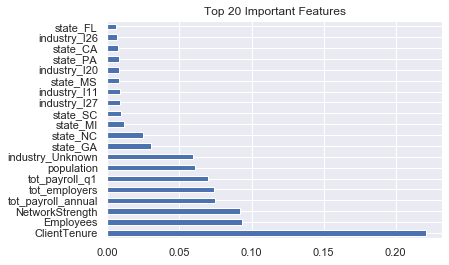

In [54]:
# Best Model and Feature importances
X_train, X_test, y_train, y_test = train_test_split(X,y)
rf = RandomForestClassifier(n_estimators=50,max_features=10,max_depth=10)
rf.fit(X_train, y_train)
plot_feature_importances(rf)

## Boosted Trees
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Model Importances
    * Partial Dependence

In [55]:
# Default parameters
from sklearn.ensemble import GradientBoostingClassifier
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(GradientBoostingClassifier(), X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.7986
Testing Set Accuracy: 0.7786


In [56]:
# Grid search
# set up dictionary for grid search
param_grid={'n_estimators':[10,25,50,75],'max_depth':[2,3,4],'learning_rate':[0.1,0.2,0.3,0.5]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# Select relevant columns
df_results_gb = results[['rank_test_score','mean_train_score','mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate']]
# Table for Grid search results
df_results_gb.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_learning_rate
0,34,0.770690,0.774856,10,2,0.100000
1,28,0.775597,0.776303,25,2,0.100000
2,12,0.781161,0.778926,50,2,0.100000
3,1,0.784267,0.780305,75,2,0.100000
4,34,0.771180,0.774856,10,3,0.100000
5,21,0.783015,0.777931,25,3,0.100000
6,7,0.790320,0.779514,50,3,0.100000
7,9,0.794768,0.779446,75,3,0.100000
8,36,0.774904,0.774675,10,4,0.100000
9,16,0.792733,0.778315,25,4,0.100000


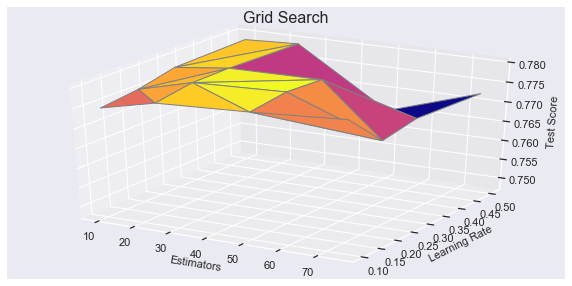

In [57]:
# 3D plot of Grid search results
# Colormap reference module
from matplotlib import cm 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = df_results_gb['param_n_estimators']
ys = df_results_gb['param_learning_rate']
zs = df_results_gb['mean_test_score']

ax.set_xlabel("Estimators",fontsize = 11)
ax.set_ylabel("Learning Rate",fontsize = 11)
ax.set_zlabel("Test Score", fontsize = 11)
ax.set_title("Grid Search", fontsize = 16)

# Aesthetics
fig.set_figheight(5)
fig.set_figwidth(10)
                
ax.plot_trisurf(xs, ys, zs,color= 'blue',edgecolor='gray', cmap=cm.plasma)

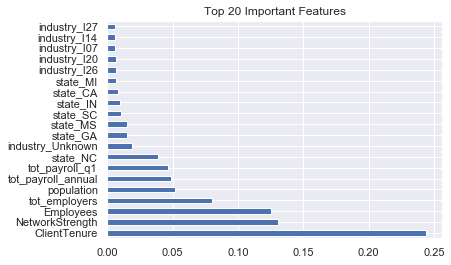

In [58]:
# Best Model and Feature importance
X_train, X_test, y_train, y_test = train_test_split(X,y)
gb = GradientBoostingClassifier(n_estimators=75,learning_rate = 0.2,max_depth=4)
gb.fit(X_train, y_train)
plot_feature_importances(gb)

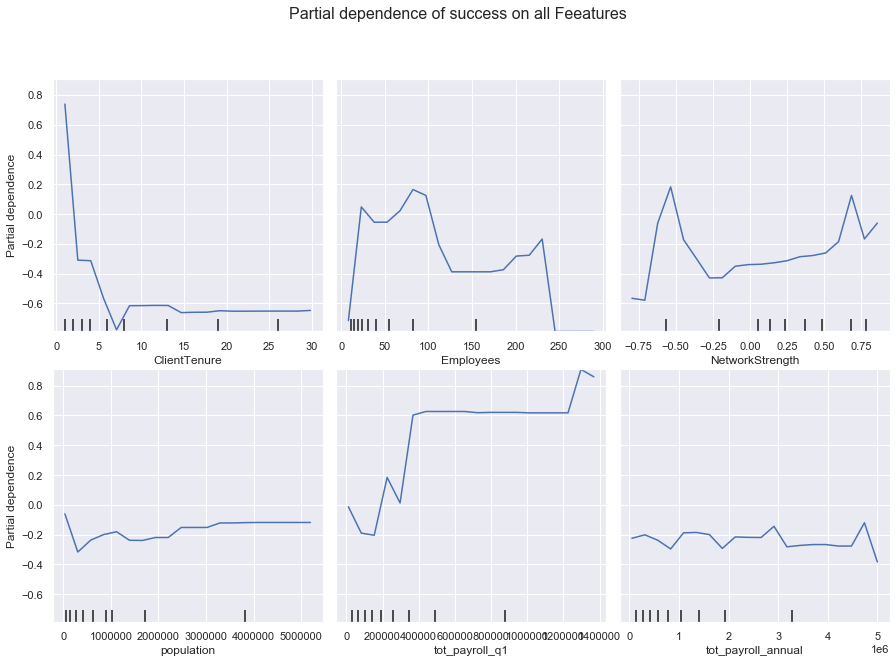

In [59]:
# Partial dependence plot

# Partial dependence plot module
from sklearn.inspection import plot_partial_dependence

# Order plots by feuture importance 
features = [1,2,0,3,4,5]
plot_partial_dependence(gb,X,features, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of success on all Feeatures',fontsize=16)
fig.subplots_adjust(wspace= 0.05, hspace=0.15)
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Neural Networks
* Default parameters
* Grid search
* Best Model
* Model Interpretation

In [60]:
from sklearn.neural_network import MLPClassifier
fullmodel = MLPClassifier(max_iter = 2000, activation = 'relu',hidden_layer_sizes = [100])
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullmodel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.7002
Testing Set Accuracy: 0.6978


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

mlp = MLPClassifier(max_iter = 2000, alpha=1, activation = 'relu',hidden_layer_sizes = [100])
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.78
Accuracy on test set: 0.75


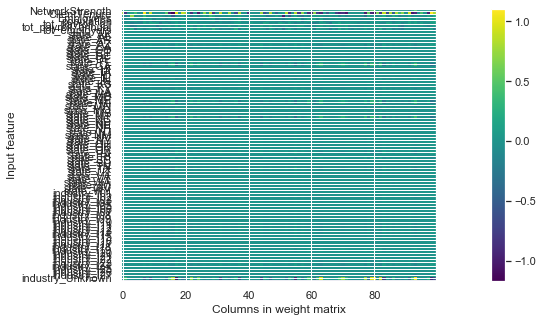

In [63]:
# Plot results
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap= 'viridis')
plt.yticks(range(87), X_train.columns)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

# Evaluation of Metrics
* Confusion Matrix of Best Model
* Threshold variations
* ROC Curve

In [64]:
# Boosted Tree
yhat = gb.predict(X_test)
cmat = confusion_matrix(y_test,yhat)
print(cmat)
tn, fp, fn, tp = cmat.ravel()
print("True Negatives:", tn, "False Positives:", fp, "False Neagtives:", fn, "True positive:", tp)

[[1306   29]
 [ 316  118]]
True Negatives: 1306 False Positives: 29 False Neagtives: 316 True positive: 118


In [65]:
# The basic values
# General accuracy
accuracy = (tp+tn)/(tp+tn+fp+fn)
# fraction of positives that are actually positive
precision = tp/(tp+fp)
# fraction of positives (power)
recall = tp/(tp+fn)
type2 = 1 - recall # type 2 error rate (1-power)
# false positive rate (size or type I error)
fpr = fp/(fp+tn)
# Some counts on errors for stats types
type1errors = fp # reject(1) true(0)
type2errors = fn # don't reject(0) true 1
print((accuracy, precision, recall, fpr))

(0.8049745618993782, 0.8027210884353742, 0.271889400921659, 0.021722846441947566)


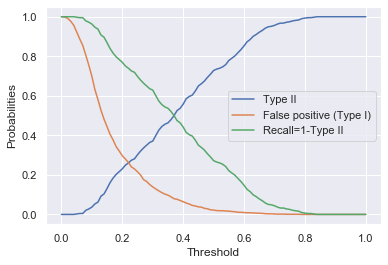

In [66]:
# This code plots type2errors, faslse positives, and recals against thesholds
thresholds = np.arange(start=0.,stop=1.01,step=0.01)
recallList = []
type2List = []
fpList = []
# make sure probs are ok
yhatp = gb.predict_proba(X_test)
for thresh in thresholds:
    yhat = yhatp[:,1]>thresh
    cmat = confusion_matrix(y_test,yhat)
    tn, fp, fn, tp = cmat.ravel()
    recallList.append( tp/(tp+fn))
    fpList.append(fp/(fp+tn))
    type2List.append(fn/(tp+fn))
plt.plot(thresholds,type2List,label='Type II')
plt.plot(thresholds,fpList,label='False positive (Type I)')
plt.plot(thresholds,recallList,label='Recall=1-Type II')
plt.xlabel('Threshold')
plt.ylabel('Probabilities')
plt.legend()

Text(0.5, 1.0, 'ROC Curve')

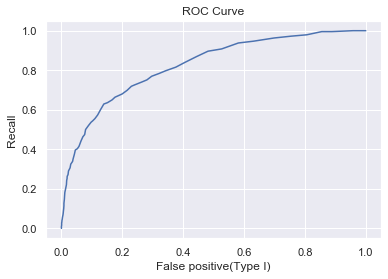

In [67]:
# Plot roc curve
plt.plot(fpList,recallList)
plt.xlabel('False positive(Type I)')
plt.ylabel('Recall')
plt.title('ROC Curve')

# Insights
* Highest accuracy achieved with Decision Trees, Random Forest, and Logistic Regression
* Feature importances also show similar patterns
* **Employees** and **ClientTenure** are consistently the most importances features in all tree-based models
* Decision Tree suggests targeting employers whose **ClientTenure** is low for increased sales of **ProductX**
* Partial dependence plot in Boosted Tree shows an initial linear relationship between sale success and employee headcount with a sharp downward trend starting from circa 60 **Employees**. This suggests higher payoff when targeting *micro*, *small* and *medium* employers